# Pluto's Orbit, and Validating Kepler's Second Law

## Eriel Wiston and Alexandra Maycock

## Q: Is Kepler's Second Law satisfied when tested against Pluto's highly eccentric orbit?

In [187]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [188]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [173]:
#Below are the initial conditions, which initialize
#PLuto's radius and velocity at perihelion (the point
#at which its distance from the sun is smallest). All
#other positions and velocities are initialized to 0.
r_0 = 4436.82e9 * m
v_0 = -6100 * m/s

init = State(x = r_0,
             y = 0 * m/s,
             vx = 0 * m / s,
             vy = v_0)

,values
x,4436820000000.0 meter
y,0.0 meter / second
vx,0.0 meter / second
vy,-6100.0 meter / second


In [175]:
#Now, we make the system object, which contains
#Pluto's radius, the sun's radius, the combined radius
#of Pluto and the sun, the State object,the masses of
#Pluto and the sun, the start and end time, and the
#gravitational constant.

r_pluto = 1187000 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_pluto,
                m2=0.01303e24 * kg,
                t_0=0 * s,
                t_end=7820000000 * s)

,values
init,x 4436820000000.0 meter y 0.0 met...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,696695000.0 meter
m2,1.303e+22 kilogram
t_0,0 second
t_end,7820000000 second


In [176]:
#This function computes the force of gravity, using
#universal gravitation.

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    r = Vector(x, y)
    v = Vector(vx, vy)
 
    force_mag = G * m1 * m2 / r.mag**2
    force = r.hat() * force_mag 
   # force = Vector(G*m1*m2/x**2, G*m1*m2/y**2)
    return force

In [177]:
universal_gravitation(init, system)

<Quantity([8.78661872e+16 0.00000000e+00], 'newton')>

In [178]:
#The slope function calculates velocity and acceleration
#for each time step in our orbit

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    

    force_x, force_y = universal_gravitation(state, system)
    dxdt = vx
    dydt = vy
    dvxdt = -force_x / m2
    dvydt = -force_y / m2
    
    return dxdt, dydt, dvxdt, dvydt

In [179]:
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-6100.0, 'meter / second')>,
 <Quantity(-6.743375839653671e-06, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [180]:
#Event function that stops the simulation upon collision

def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x,y)
    return position.mag - system.r_final

In [181]:
events = event_func(init, 0, system)

<Quantity(4436123305000.0, 'meter')>

In [182]:
#Here, we test all the functions together

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[]]
nfev,158
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [184]:
#We do not expect Pluto to collide with the sun in 
#its regular orbit, so our final time should be a 
#full year, which is how many seconds we started with

t_final = get_last_label(results) * s

<Quantity(7820000000.0, 'second')>

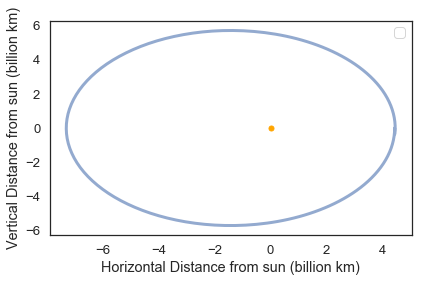

In [186]:
ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23', t_eval=ts)

#Our results are scaled to Earth days
results.index /= 60 * 60 * 24

#And to billions of kilometers, and plotted
x = results.x / 1e12;
y = results.y /1e12;
plot(x, y)

#Look! The sun is an orange dot! Isn't that neat?
plt.plot(0, 0, marker='o', markersize=5, color="orange")

decorate(xlabel='Horizontal Distance from sun (billion km)',
         ylabel='Vertical Distance from sun (billion km)')